# Create embeddings and investigate quality of raw data

My first attempt using bert models and huggingface transformers.

In [ ]:
# basics
import os
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle

import nltk
from nltk.corpus import stopwords
import re

# bert transformers, huggingace, etc
from sentence_transformers import SentenceTransformer, util

# we are using some less optimal code, suppress the warnings for now
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

nltk.download('stopwords')

## Similarity between two texts

We compute the cosine similarity between embeddings, for example, to measure the semantic similarity of two texts. 
For this, we pick a smaller set from the orig data, i.e. all github issues that carry the label `area/hibernate-orm` already. 

Why? Issues with the same (github) label are classified manually already. We can use this knowledge to validate the similarity scores before we move further with the implementation.

### Sentence to sentence comparison

How well do arbitray sentences (the issue `body` in this case) compare using cosine similarity of the embeddings?

Loading issues from file...


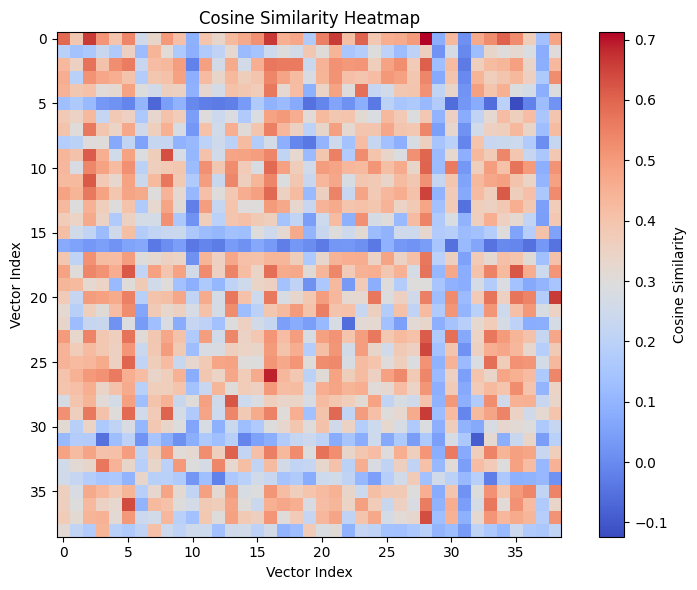

In [2]:

gh_label = 'area/hibernate-orm' #'area/devmode'
model = SentenceTransformer('all-MiniLM-L6-v2')

print("Loading issues from file...")
unique_labels = pickle.load(open("../data/raw/labels.pkl", 'rb'))
df = pickle.load(open("../data/prepared/issues.pkl", 'rb'))
same_label_df = df[df[gh_label] == 1]

# create equally sizes df's
if (len(same_label_df) % 2) > 0:
    same_label_df.drop(same_label_df.tail(1).index,inplace=True)
df1, df2 = np.split(same_label_df, 2)

# clean the markdown output in the original github issues texts. 
# There are too many false positives derived from this
def clean(x, stopWords=stopwords.words('english')):    
    if x == None: return x       
    x = re.sub(r'^(#.*?)$', '', x, flags=re.MULTILINE)        
    x = re.sub(r'^(\*\*.*?\*\*)$', '', x, flags=re.MULTILINE)        
    wordsFiltered = []
    for w in x.split():
        if w not in stopWords:
            wordsFiltered.append(w)
    return " ".join(wordsFiltered)        

df1['clean_body'] = df1.apply(lambda x: clean(x['body']), axis=1)
df2['clean_body'] = df2.apply(lambda x: clean(x['body']), axis=1)

# Two lists of sentences
sentences1 = df1['clean_body'].to_numpy()
sentences2 = df2['clean_body'].to_numpy()

# #Compute embedding for both lists
embeddings1 = model.encode(sentences1, convert_to_tensor=True)
embeddings2 = model.encode(sentences2, convert_to_tensor=True)

#Compute cosine-similarities
cosine_scores = util.cos_sim(embeddings1, embeddings2)

# an attempt to visualize the data
tensor = cosine_scores.numpy()

# Create a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(cosine_scores, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Cosine Similarity')
plt.title('Cosine Similarity Heatmap')
plt.xlabel('Vector Index')
plt.ylabel('Vector Index')
plt.tight_layout()
plt.show()

Our previous comparison shows low similarity scores for the majority of issues 

### Pairs with the highest cosine similarity scores

Lets try find the ones with the highest degree of similarity, to see if we can learn something from it.

In [3]:
# Single list of sentences
sentences = [*sentences1, *sentences2]
print("Total sentences: ", len(sentences))

#Compute embeddings
embeddings = model.encode(sentences, convert_to_tensor=True)

#Compute cosine-similarities for each sentence with each other sentence
cosine_scores = util.cos_sim(embeddings, embeddings)

#Find the pairs with the highest cosine similarity scores
pairs = []
for i in range(len(cosine_scores)-1):
    for j in range(i+1, len(cosine_scores)):
        pairs.append({'index': [i, j], 'score': cosine_scores[i][j]})

#Sort scores in decreasing order
pairs = sorted(pairs, key=lambda x: x['score'], reverse=True)

output = pd.DataFrame(columns=['A', 'B', 'Score'])

for pair in pairs[0:10]:
    i, j = pair['index']
    new_row = {'A':sentences[i], 'B':sentences[j], 'Score':pair['score']}
    output = output.append(new_row, ignore_index=True)    

output.head()



Total sentences:  78


,A,B,Score
0,Quarkus crashes startup `NullPointerException`...,**Describe bug** Simply adding `quarkus-flyway...,tensor(0.7120)
1,This came looking https://github.com/quarkusio...,Related to: **Quarkus 3.0.0.Alpha5 Hibernate O...,tensor(0.7022)
2,If I concurrently lock (`PESSIMISTIC_WRITE`) m...,My project JPA entity annotated `@UniqueConstr...,tensor(0.6891)
3,A caught `NoResultException` within transactio...,I'm trying migrate EJB code. Simple reproducer...,tensor(0.6759)
4,Quarkus crashes startup `NullPointerException`...,Related to: **Quarkus 3.0.0.Alpha5 Hibernate O...,tensor(0.6716)
